# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {128, 256, 512, 1024}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.

This might take a while to run, so plan your time carefully.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
# YOUR CODE HERE
from common_utils import MLP, intialise_loaders, train_loop, test_loop

3. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [3]:
from common_utils import split_dataset, preprocess_dataset

def preprocess(df):
    # Preporocessing
    f_columns_to_drop = ['label', 'filename'] #These columns are dropped to get only the features
    X_train_notscaled, y_train, X_test_notscaled, y_test = split_dataset(df, columns_to_drop = f_columns_to_drop, test_size = 0.3, random_state = 0)
    return X_train_notscaled, y_train, X_test_notscaled, y_test


df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]
df['label'].value_counts()
X_train_notscaled, y_train, X_test_notscaled, y_test = preprocess(df)


In [4]:
from common_utils import preprocess_dataset
def generate_cv_folds_for_batch_sizes(parameters, X_train, y_train):
    """
    returns:
    X_train_scaled_dict(dict) where X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict(dict) where X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds.
    y_train_dict(dict) where y_train_dict[batch_size] is a list of labels for the different folds
    y_val_dict(dict) where y_val_dict[batch_size] is a list of labels for the different folds
    """
    # YOUR CODE HERE
    X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = {}, {}, {}, {}
    for batch in parameters:
        cv = KFold(n_splits=no_folds, shuffle=True, random_state=1)
        X_train_scaled_dict[batch] = []
        X_val_scaled_dict[batch] = []
        y_train_dict[batch] = []
        y_val_dict[batch] = []
        for train_idx, val_idx in cv.split(X_train, y_train):
            x_train, y_train_1  = X_train[train_idx], y_train[train_idx]
            x_val, y_val = X_train[val_idx], y_train[val_idx]
            X_train_scaled, X_val_scaled = preprocess_dataset(x_train, x_val)
            
            X_train_scaled_dict[batch].append(X_train_scaled)
            X_val_scaled_dict[batch].append(X_val_scaled)
            y_train_dict[batch].append(y_train_1)
            y_val_dict[batch].append(y_val)
        
            
    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

no_folds = 5
batch_sizes = [128, 256, 512, 1024]
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_sizes, X_train_notscaled.to_numpy(), y_train)

4. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [5]:
from common_utils import EarlyStopper
model_no_features = 77
model_no_hidden = 128
model_no_labels = 1
learning_rate = 0.001
epochs = 50
es_patience = 3

In [6]:
# YOUR CODE HERE
import time
def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, hyperparameter):
    cross_validation_accuracies_dict = {}
    cross_validation_times_dict = {}
    for batch_size_1 in batch_sizes:
        print(batch_size_1)
        print("----------------------------------")
        print("\n")
        val_classification_accuracy = [] # A list that temporarily stores the number of classification accuracy in the last epoch of every experiment for a particular batch size
        elapsed_time_lepoch = [] # A list that temporarily stores the time taken to train the last epoch of every experiment for a particular batch size
        for n in range(len(X_train_scaled_dict[batch_size_1])):
            print(f"Experiment {n+1}")
            X_train_batch = X_train_scaled_dict[batch_size_1][n]
            X_val_batch = X_val_scaled_dict[batch_size_1][n]
            y_train_batch = y_train_dict[batch_size_1][n]
            y_val_batch = y_val_dict[batch_size_1][n]
            
            train_dataloader, val_dataloader = intialise_loaders(X_train_batch, y_train_batch, X_val_batch, y_val_batch, batch_size_1)
            
            earlyStop = EarlyStopper(patience = es_patience)
            model = MLP(no_features = model_no_features, no_hidden = model_no_hidden, no_labels = model_no_labels)
            optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 
            loss_fn = nn.BCELoss()
            
            for t in range(epochs):
                start_time = time.time()
                train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer) # In mini batch gradient descent in one epoch the model is trained on all batches
                end_time = time.time()
                val_loss, val_correct = test_loop(val_dataloader, model, loss_fn)
                elapsed_time = end_time - start_time
                print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*val_correct):>0.2f}%, Test_loss: {val_loss:>8f}")
                print("\n")
                # print(elapsed_time) Debugging
                if earlyStop.early_stop(val_loss): 
                    print("Done!")
                    print("\n")
                    break
            
            
            elapsed_time_last_epoch = elapsed_time
            elapsed_time_lepoch.append(elapsed_time_last_epoch)
            
            val_accuracy_for_last_epoch = val_correct
            val_classification_accuracy.append(val_accuracy_for_last_epoch)
        
        # print(elapsed_time_lepoch) Debugging
        average_time_lepoch = np.mean(elapsed_time_lepoch)
        #average_time_lepoch = "{:.2f}".format(average_time_lepoch_1)
        # print(len(val_classification_accuracy)) Debugging
        average_classification_accuracy = np.mean(val_classification_accuracy)
        #average_classification_accuracy = "{:.2f}".format(average_classification_accuracy_1)
        # print(average_classification_accuracy) Debugging
        cross_validation_accuracies_dict[batch_size_1] = average_classification_accuracy
        cross_validation_times_dict[batch_size_1] = average_time_lepoch
    return cross_validation_accuracies_dict, cross_validation_times_dict 

batch_sizes = [128, 256, 512, 1024]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, 'batch_size')


128
----------------------------------


Experiment 1
loss: 0.691208  [  128/ 6751]
Train Error: 
 Accuracy: 54.0%, Avg loss: 0.687314 

Test Error: 
 Accuracy: 57.3%, Avg loss: 0.682745 

Epoch 1: Train_accuracy: 53.96%, Train_loss: 0.687314, Test_accuracy: 57.29%, Test_loss: 0.682745


loss: 0.684178  [  128/ 6751]
Train Error: 
 Accuracy: 57.9%, Avg loss: 0.673916 

Test Error: 
 Accuracy: 58.4%, Avg loss: 0.669261 

Epoch 2: Train_accuracy: 57.93%, Train_loss: 0.673916, Test_accuracy: 58.35%, Test_loss: 0.669261


loss: 0.617060  [  128/ 6751]
Train Error: 
 Accuracy: 61.6%, Avg loss: 0.657224 

Test Error: 
 Accuracy: 60.8%, Avg loss: 0.662261 

Epoch 3: Train_accuracy: 61.59%, Train_loss: 0.657224, Test_accuracy: 60.84%, Test_loss: 0.662261


loss: 0.620799  [  128/ 6751]
Train Error: 
 Accuracy: 62.2%, Avg loss: 0.646818 

Test Error: 
 Accuracy: 61.3%, Avg loss: 0.651992 

Epoch 4: Train_accuracy: 62.21%, Train_loss: 0.646818, Test_accuracy: 61.26%, Test_loss: 0.651992


loss: 

Train Error: 
 Accuracy: 73.5%, Avg loss: 0.533615 

Test Error: 
 Accuracy: 66.2%, Avg loss: 0.639261 

Epoch 11: Train_accuracy: 73.50%, Train_loss: 0.533615, Test_accuracy: 66.17%, Test_loss: 0.639261


loss: 0.493420  [  128/ 6751]
Train Error: 
 Accuracy: 74.5%, Avg loss: 0.513988 

Test Error: 
 Accuracy: 68.4%, Avg loss: 0.627973 

Epoch 12: Train_accuracy: 74.46%, Train_loss: 0.513988, Test_accuracy: 68.42%, Test_loss: 0.627973


loss: 0.479303  [  128/ 6751]
Train Error: 
 Accuracy: 75.8%, Avg loss: 0.497024 

Test Error: 
 Accuracy: 67.5%, Avg loss: 0.624658 

Epoch 13: Train_accuracy: 75.83%, Train_loss: 0.497024, Test_accuracy: 67.48%, Test_loss: 0.624658


Done!


Experiment 4
loss: 0.695845  [  128/ 6751]
Train Error: 
 Accuracy: 54.9%, Avg loss: 0.685868 

Test Error: 
 Accuracy: 57.5%, Avg loss: 0.680395 

Epoch 1: Train_accuracy: 54.85%, Train_loss: 0.685868, Test_accuracy: 57.52%, Test_loss: 0.680395


loss: 0.660630  [  128/ 6751]
Train Error: 
 Accuracy: 58.9%, Avg 

Train Error: 
 Accuracy: 79.3%, Avg loss: 0.440313 

Test Error: 
 Accuracy: 67.9%, Avg loss: 0.604020 

Epoch 19: Train_accuracy: 79.27%, Train_loss: 0.440313, Test_accuracy: 67.87%, Test_loss: 0.604020


loss: 0.442150  [  128/ 6752]
Train Error: 
 Accuracy: 80.0%, Avg loss: 0.422427 

Test Error: 
 Accuracy: 66.6%, Avg loss: 0.645715 

Epoch 20: Train_accuracy: 79.99%, Train_loss: 0.422427, Test_accuracy: 66.57%, Test_loss: 0.645715


loss: 0.365176  [  128/ 6752]
Train Error: 
 Accuracy: 80.4%, Avg loss: 0.413337 

Test Error: 
 Accuracy: 69.4%, Avg loss: 0.620327 

Epoch 21: Train_accuracy: 80.41%, Train_loss: 0.413337, Test_accuracy: 69.35%, Test_loss: 0.620327


loss: 0.343490  [  128/ 6752]
Train Error: 
 Accuracy: 81.6%, Avg loss: 0.411131 

Test Error: 
 Accuracy: 68.5%, Avg loss: 0.656935 

Epoch 22: Train_accuracy: 81.58%, Train_loss: 0.411131, Test_accuracy: 68.52%, Test_loss: 0.656935


Done!


256
----------------------------------


Experiment 1
loss: 0.692264  [  256/ 

Train Error: 
 Accuracy: 58.1%, Avg loss: 0.676201 

Test Error: 
 Accuracy: 56.6%, Avg loss: 0.679664 

Epoch 2: Train_accuracy: 58.12%, Train_loss: 0.676201, Test_accuracy: 56.58%, Test_loss: 0.679664


loss: 0.652921  [  256/ 6751]
Train Error: 
 Accuracy: 60.2%, Avg loss: 0.661773 

Test Error: 
 Accuracy: 58.9%, Avg loss: 0.676860 

Epoch 3: Train_accuracy: 60.20%, Train_loss: 0.661773, Test_accuracy: 58.89%, Test_loss: 0.676860


loss: 0.637718  [  256/ 6751]
Train Error: 
 Accuracy: 62.0%, Avg loss: 0.650017 

Test Error: 
 Accuracy: 58.4%, Avg loss: 0.669101 

Epoch 4: Train_accuracy: 62.02%, Train_loss: 0.650017, Test_accuracy: 58.35%, Test_loss: 0.669101


loss: 0.639866  [  256/ 6751]
Train Error: 
 Accuracy: 63.4%, Avg loss: 0.638087 

Test Error: 
 Accuracy: 59.2%, Avg loss: 0.661185 

Epoch 5: Train_accuracy: 63.44%, Train_loss: 0.638087, Test_accuracy: 59.18%, Test_loss: 0.661185


loss: 0.620934  [  256/ 6751]
Train Error: 
 Accuracy: 65.6%, Avg loss: 0.618770 

Test Er

Train Error: 
 Accuracy: 72.5%, Avg loss: 0.542232 

Test Error: 
 Accuracy: 65.6%, Avg loss: 0.642966 

Epoch 13: Train_accuracy: 72.45%, Train_loss: 0.542232, Test_accuracy: 65.56%, Test_loss: 0.642966


loss: 0.512577  [  256/ 6752]
Train Error: 
 Accuracy: 72.8%, Avg loss: 0.536365 

Test Error: 
 Accuracy: 66.6%, Avg loss: 0.615496 

Epoch 14: Train_accuracy: 72.84%, Train_loss: 0.536365, Test_accuracy: 66.63%, Test_loss: 0.615496


loss: 0.511763  [  256/ 6752]
Train Error: 
 Accuracy: 74.7%, Avg loss: 0.508934 

Test Error: 
 Accuracy: 65.4%, Avg loss: 0.642080 

Epoch 15: Train_accuracy: 74.69%, Train_loss: 0.508934, Test_accuracy: 65.38%, Test_loss: 0.642080


loss: 0.522009  [  256/ 6752]
Train Error: 
 Accuracy: 75.6%, Avg loss: 0.502155 

Test Error: 
 Accuracy: 66.4%, Avg loss: 0.637717 

Epoch 16: Train_accuracy: 75.58%, Train_loss: 0.502155, Test_accuracy: 66.39%, Test_loss: 0.637717


loss: 0.488840  [  256/ 6752]
Train Error: 
 Accuracy: 76.4%, Avg loss: 0.488714 

Tes

Train Error: 
 Accuracy: 68.2%, Avg loss: 0.598220 

Test Error: 
 Accuracy: 64.1%, Avg loss: 0.638534 

Epoch 12: Train_accuracy: 68.18%, Train_loss: 0.598220, Test_accuracy: 64.10%, Test_loss: 0.638534


loss: 0.585601  [  512/ 6751]
Train Error: 
 Accuracy: 69.0%, Avg loss: 0.581865 

Test Error: 
 Accuracy: 63.6%, Avg loss: 0.624791 

Epoch 13: Train_accuracy: 68.98%, Train_loss: 0.581865, Test_accuracy: 63.57%, Test_loss: 0.624791


loss: 0.570358  [  512/ 6751]
Train Error: 
 Accuracy: 69.3%, Avg loss: 0.585123 

Test Error: 
 Accuracy: 64.6%, Avg loss: 0.626195 

Epoch 14: Train_accuracy: 69.26%, Train_loss: 0.585123, Test_accuracy: 64.57%, Test_loss: 0.626195


loss: 0.565979  [  512/ 6751]
Train Error: 
 Accuracy: 70.1%, Avg loss: 0.568808 

Test Error: 
 Accuracy: 67.4%, Avg loss: 0.618208 

Epoch 15: Train_accuracy: 70.12%, Train_loss: 0.568808, Test_accuracy: 67.42%, Test_loss: 0.618208


loss: 0.540509  [  512/ 6751]
Train Error: 
 Accuracy: 70.3%, Avg loss: 0.557891 

Tes

Test Error: 
 Accuracy: 57.0%, Avg loss: 0.683396 

Epoch 2: Train_accuracy: 56.46%, Train_loss: 0.683163, Test_accuracy: 56.97%, Test_loss: 0.683396


loss: 0.677833  [  512/ 6752]
Train Error: 
 Accuracy: 58.1%, Avg loss: 0.672503 

Test Error: 
 Accuracy: 57.1%, Avg loss: 0.673960 

Epoch 3: Train_accuracy: 58.06%, Train_loss: 0.672503, Test_accuracy: 57.14%, Test_loss: 0.673960


loss: 0.668766  [  512/ 6752]
Train Error: 
 Accuracy: 59.8%, Avg loss: 0.661113 

Test Error: 
 Accuracy: 59.0%, Avg loss: 0.663519 

Epoch 4: Train_accuracy: 59.76%, Train_loss: 0.661113, Test_accuracy: 58.98%, Test_loss: 0.663519


loss: 0.670450  [  512/ 6752]
Train Error: 
 Accuracy: 61.9%, Avg loss: 0.656705 

Test Error: 
 Accuracy: 60.5%, Avg loss: 0.665909 

Epoch 5: Train_accuracy: 61.89%, Train_loss: 0.656705, Test_accuracy: 60.52%, Test_loss: 0.665909


loss: 0.614527  [  512/ 6752]
Train Error: 
 Accuracy: 63.3%, Avg loss: 0.647021 

Test Error: 
 Accuracy: 60.0%, Avg loss: 0.662530 

Epoch 6:

loss: 0.636501  [ 1024/ 6751]
Train Error: 
 Accuracy: 62.8%, Avg loss: 0.643065 

Test Error: 
 Accuracy: 61.4%, Avg loss: 0.654279 

Epoch 9: Train_accuracy: 62.78%, Train_loss: 0.643065, Test_accuracy: 61.37%, Test_loss: 0.654279


loss: 0.628926  [ 1024/ 6751]
Train Error: 
 Accuracy: 64.2%, Avg loss: 0.634546 

Test Error: 
 Accuracy: 61.7%, Avg loss: 0.648604 

Epoch 10: Train_accuracy: 64.18%, Train_loss: 0.634546, Test_accuracy: 61.67%, Test_loss: 0.648604


loss: 0.624181  [ 1024/ 6751]
Train Error: 
 Accuracy: 65.5%, Avg loss: 0.627137 

Test Error: 
 Accuracy: 61.6%, Avg loss: 0.652780 

Epoch 11: Train_accuracy: 65.50%, Train_loss: 0.627137, Test_accuracy: 61.61%, Test_loss: 0.652780


loss: 0.629669  [ 1024/ 6751]
Train Error: 
 Accuracy: 65.8%, Avg loss: 0.620852 

Test Error: 
 Accuracy: 62.1%, Avg loss: 0.646656 

Epoch 12: Train_accuracy: 65.80%, Train_loss: 0.620852, Test_accuracy: 62.14%, Test_loss: 0.646656


loss: 0.626491  [ 1024/ 6751]
Train Error: 
 Accuracy: 66

Train Error: 
 Accuracy: 74.0%, Avg loss: 0.523060 

Test Error: 
 Accuracy: 64.8%, Avg loss: 0.638014 

Epoch 23: Train_accuracy: 73.96%, Train_loss: 0.523060, Test_accuracy: 64.81%, Test_loss: 0.638014


Done!


Experiment 4
loss: 0.693226  [ 1024/ 6751]
Train Error: 
 Accuracy: 51.8%, Avg loss: 0.692345 

Test Error: 
 Accuracy: 53.0%, Avg loss: 0.689185 

Epoch 1: Train_accuracy: 51.78%, Train_loss: 0.692345, Test_accuracy: 52.96%, Test_loss: 0.689185


loss: 0.686874  [ 1024/ 6751]
Train Error: 
 Accuracy: 55.4%, Avg loss: 0.687100 

Test Error: 
 Accuracy: 55.3%, Avg loss: 0.686794 

Epoch 2: Train_accuracy: 55.40%, Train_loss: 0.687100, Test_accuracy: 55.33%, Test_loss: 0.686794


loss: 0.688738  [ 1024/ 6751]
Train Error: 
 Accuracy: 57.2%, Avg loss: 0.681492 

Test Error: 
 Accuracy: 56.9%, Avg loss: 0.678061 

Epoch 3: Train_accuracy: 57.21%, Train_loss: 0.681492, Test_accuracy: 56.87%, Test_loss: 0.678061


loss: 0.668417  [ 1024/ 6751]
Train Error: 
 Accuracy: 58.3%, Avg lo

In [8]:
print(f"cross_validation_accuracies for different batch sizes:\n{cross_validation_accuracies}")
print("\n")
print(f"cross_validation_times for different batch sizes:\n{cross_validation_times}")

accuracy_keys_list = list(cross_validation_accuracies.keys())
accuracy_values_list = list(cross_validation_accuracies.values())

times_keys_list = list(cross_validation_times.keys())
times_values_list = list(cross_validation_times.values())


cross_validation_accuracies for different batch sizes:
{128: 0.6797020426624563, 256: 0.6536333742558791, 512: 0.6394103079866388, 1024: 0.6383438870425361}


cross_validation_times for different batch sizes:
{128: 0.15106115341186524, 256: 0.11024775505065917, 512: 0.08696017265319825, 1024: 0.0726020336151123}


5. Plot scatterplot of mean cross validation accuracies for the different batch sizes.

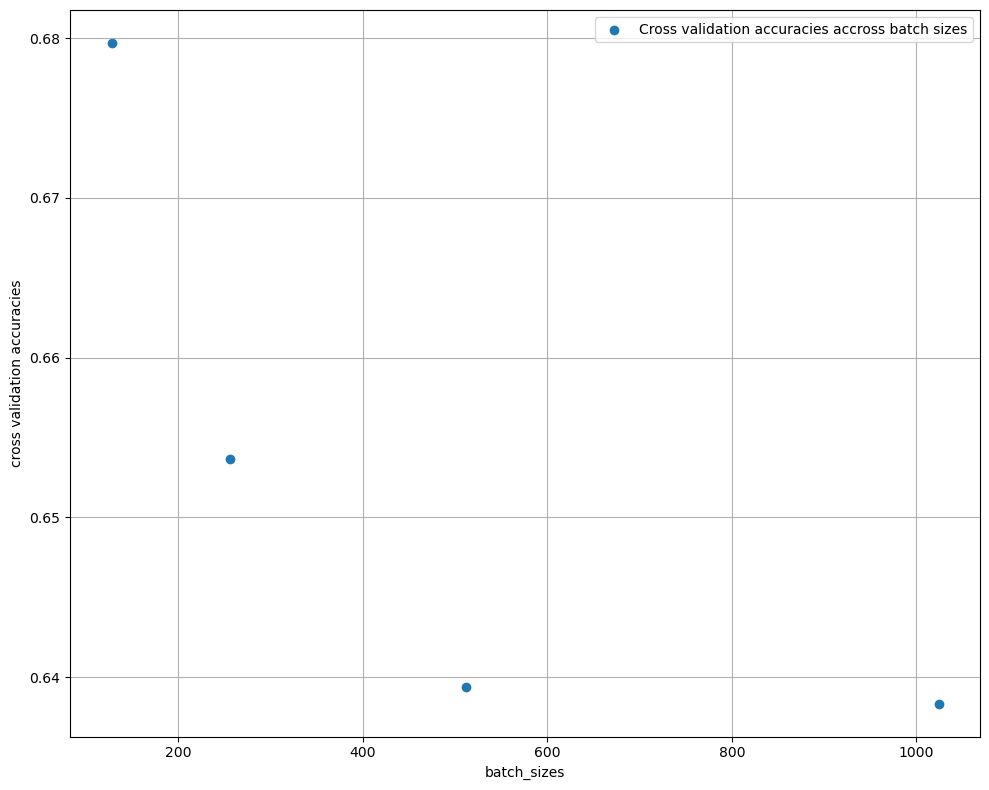

In [9]:
# YOUR CODE HERE
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.scatter(accuracy_keys_list, accuracy_values_list, label='Cross validation accuracies accross batch sizes')


plt.xlabel('batch_sizes')
plt.ylabel('cross validation accuracies')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

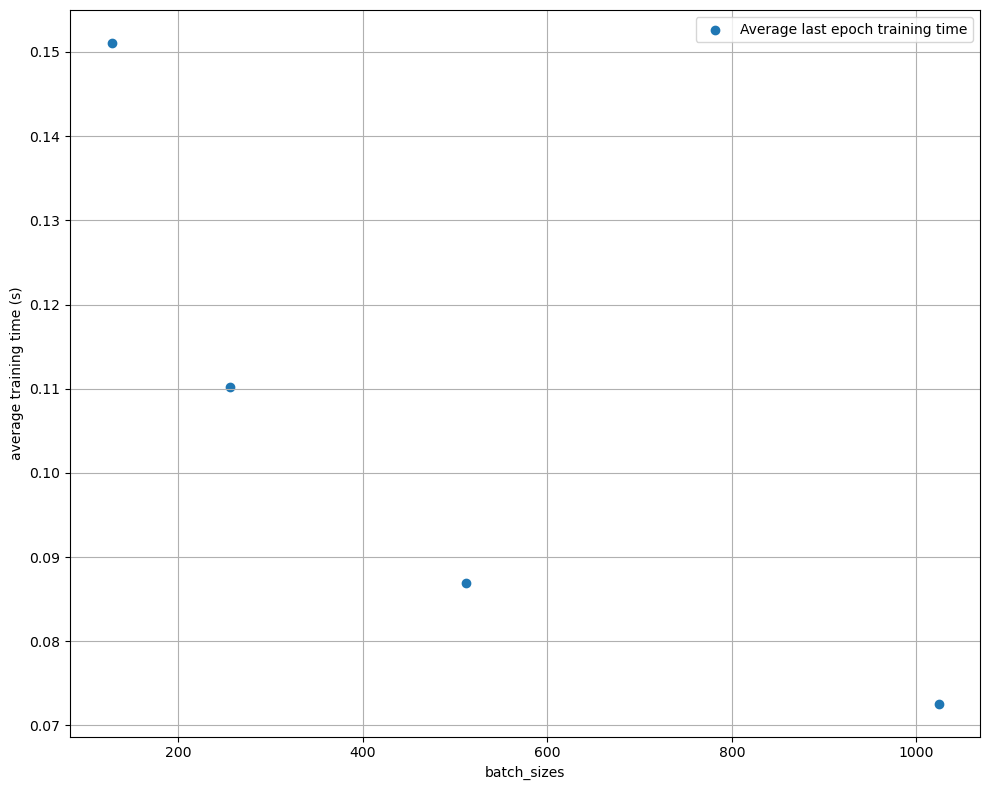

In [10]:
# YOUR CODE HERE
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.scatter(times_keys_list, times_values_list, label='Average last epoch training time')


plt.xlabel('batch_sizes')
plt.ylabel('average training time (s)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

6. Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [11]:
df = pd.DataFrame({'Batch Size': times_keys_list, 'Last Epoch Time': times_values_list})
df

,Batch Size,Last Epoch Time
0,128,0.151061
1,256,0.110248
2,512,0.086960
3,1024,0.072602


In [12]:
# YOUR CODE HERE
optimal_batch_size = 128
reason = "The model trained with training data with batch size of 128 has the highest mean cross validation accuracy. At the same time, training the model with this batch size takes higher time because of fewer parallel operations compared to those in higher batch sizes but this is expected."